# NLP 機器學習:自然語言處理實務
# (讓電腦擁有理解人類語言的能力，就是自然語言處理 (Natural Language Processing，縮寫 NLP)。
## 授課教師: 黃志泰
## 實作教材手冊初編撰日期:2019.2.01
## 實作內容:實作與訓練學習 Python+NLP+ChatGpt
## 實作訓練時數:15~18小時
## 備註:
<hr>

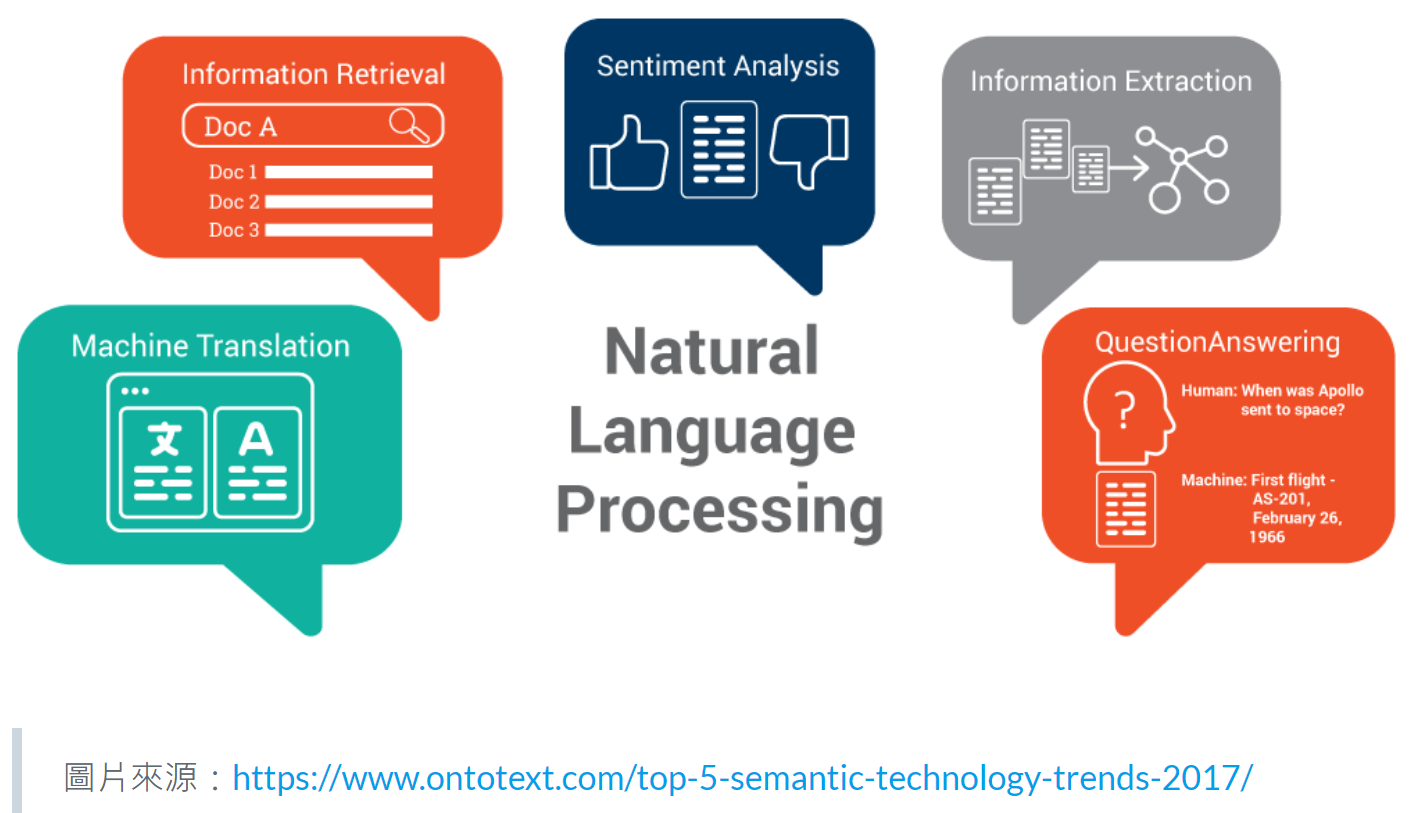

# <li>文本情感分析(sentiment analysis)(NLP應用四)
    
### 我们希望得到的是人们对一件事情评价的情感倾向。比如支持还是反对一件事情，喜欢一件产品与否--结果可能是积极的，消极的或者中立的。比如
### ==>特别喜欢这种可爱的小狗
###       这句话的情感倾向显而易见是正面的。
### 目前常见的情感极性分析方法主要是两种：基于情感词典(規則)的方法和基于机器学习的方法。
### 通常情感打分的方式 以文本情感极性判断，EX:score > 0判断为正向，score < 0判断为负向。
## 計算方式 
## 情感分析=对象∗观点∗ 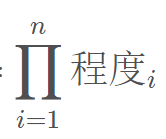


### 程度词和否定词可以合并，如：很（1.5）+不（-1）=很不（-1.5）
### 程度词和观点词可以合并，如：最（2）+差（-1）=最差（-2）
显性观点：好、差、正常、合理…
隐性观点：大、小、多、少、厚、薄…
<table>
<thead>
<tr>
<th>句子</th>
<th>对象</th>
<th>观点</th>
<th>观点类型</th>
<th>程度（含否定）</th>
<th>得分</th>
</tr>
</thead>
<tbody>
<tr>
<td>价格真tm高</td>
<td>价格（-1）</td>
<td>高（1）</td>
<td>隐性观点</td>
<td>真tm（2）</td>
<td>-1 * 1 * 2 = -2</td>
</tr>
<tr>
<td>价格没有不合理</td>
<td>价格（-1）</td>
<td>合理（1）</td>
<td>显性观点</td>
<td>没有（-1）不（-1）</td>
<td>1*(-1)^2=1</td>
</tr>
</tbody>
</table>

## A. 基于情感词典的文本情感极性分析

### STEP1:準備情感词典及对应分数
#### 词典来源于BosonNLP数据下载的情感词典，来源于社交媒体文本，所以词典适用于处理社交媒体的情感分析。
https://bosonnlp.com/dev/resource
#### 常用情感詞典：詞典來源於BosonNLP數據下載的情感詞典 BosonNLP_sentiment_score.txt
#### 否定詞詞典:（要自己手動構建）構建常見否定詞詞典 notDict.txt
##### 否定词的出现将直接将句子情感转向相反的方向，而且通常效用是叠加的。
#### 程度副詞詞典：《知網》情感分析用詞語集（beta版）（自己手動爲詞打分）degreeDict.txt
https://link.jianshu.com/?t=http://www.keenage.com/download/sentiment.rar
##### 既是通过打分的方式判断文本的情感正负，那么分数绝对值的大小则通常表示情感强弱。既涉及到程度强弱的问题，那么程度副词的引入就是势在必行的。词典内数据格式可参考如下格式，即共两列，第一列为程度副词，第二列是程度数值，> 1表示强化情感，< 1表示弱化情感。
#### 中文停用詞 :（自己手動構建）構建常見無用詞詞典stop_words.txt
### 可下載現有的: https://github.com/chdd/weibo/tree/master/stopwords

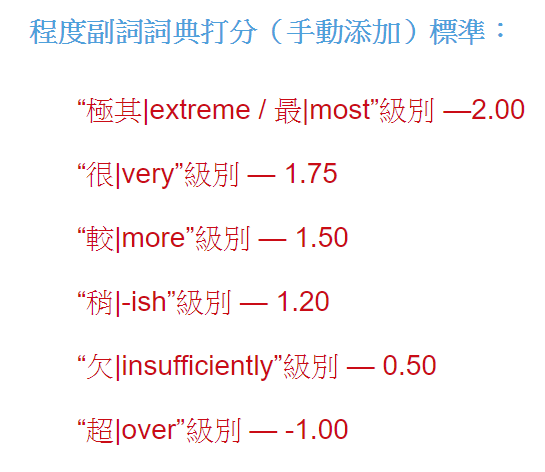

### STEP2:建構文本分詞(斷詞)處理function及情感分析模型


In [1]:
# 导入中文分词相关工具包
from collections import defaultdict
import os, re, codecs
import jieba
import matplotlib.pyplot as mp

In [2]:
# 定义句子分词函数
def sent2word(sentence,stopwords):
    # 句子分词处理
    segList = jieba.cut(sentence)
    words = []
    for word in segList:
        if word not in stopwords:
            words.append(word) 
    return words

In [3]:
# 构建分词情感分类模型（情感分析）
def classifyWords(words): 
    # (1) 情感词,讀取情感词文件
    senDict = defaultdict()
    with open('NLP_sentiment_score/BosonNLP_sentiment_score.txt', 'r', 
              encoding='utf-8') as f:
        senList = f.readlines()
    # 用评语和评分标签（二分）构建字典
    for st in senList:
        sen = st.strip().split(' ')
        if len(sen) <2:
            continue
        senDict[sen[0]] = sen[1]
    
    # (2) 否定词,讀取否定词文件
    with open('NLP_sentiment_score/notDict.txt', 'r',
              encoding='utf-8') as f:
        negLists = f.readlines()
        # 否定词处理
        negList = []
        for neg in negLists:
            neg = neg.strip()
            if not neg:
                continue
            negList.append(neg)

    # (3) 程度副词,讀取程度副词文件
    with open('NLP_sentiment_score/degreeDict.txt','r',
              encoding='utf-8') as f:
        degreeList = f.readlines()
    degreeDict = defaultdict()
    for dg in degreeList:
        degree = dg.strip().split('\t')
        degreeDict[degree[0]] = degree[1]

    
    # 情感词处理
    senWord = defaultdict()
    negWord = defaultdict()
    degreeWord = defaultdict()
      # 细化分词的词性感情色彩特征
    for idx,wd in enumerate(words):
        if wd in senDict.keys() and wd not in\
        negList and wd not in degreeDict.keys():
            senWord[idx] = senDict[wd]
        elif wd in negList and wd not in degreeDict.keys():
            negWord[idx] = -1
        elif wd in degreeDict.keys():
            degreeWord[idx] = degreeDict[wd]
    
    return senWord, negWord, degreeWord

#### ==>計算句子感情分析得分
 #### 情感分數計算邏輯：所有情感詞語組的分數之和
 #### 得分公式：單句最後得分sen_score = (-1)^(否定Word數量)x(程度副詞Word數量)x(句子得分)
 #### 總分合計：final_score = sum(sen_score)

In [4]:
# 定义情感得分函数
def scoreSent(senWord, negWord, degreeWord, words):
    W = 1
    score = 0
    # 存储所有情感词位置的列表
    senLoc = list(senWord.keys())
    negLoc = list(negWord.keys())
    degreeLoc = list(degreeWord.keys())
    senloc = -1
    
    # 遍历句子中所有单词的segResult,i为单词的绝对位置
    for i in range(len(words)):
        # 如果该词为情感词
        if i in senLoc:
            # loc 为情感词位置列表的序号
            senloc += 1
            # 直接添加该情感词分数
            score += W * float(senWord[i])
            # print("score = %f"% score)
            if senloc < len(senLoc) - 1:
                # 判断该情感词与下一情感词之间是否存在否定词或程度副词
                # j为绝对位置
                for j in range(senLoc[senloc], senLoc[senloc+1]):
                    # 如果含有否定词
                    if j in negLoc:
                        W *= -1
                    # 如果含有程度副词
                    elif j in degreeLoc:
                        W *= float(degreeWord[j])
    return score

### STEP3:讀取要做情感分析的文本及停用詞檔


In [5]:
sens = []
with open('c_news.txt','r',
          encoding='utf-8') as f:
    datas = f.readlines()
    
    for data in datas:
        sen = data.strip()
        sens.append(sen)
print(len(sens))

14


In [6]:
# 获取停用词列表
with open('NLP_sentiment_score/stop_words.txt','r',encoding='utf-8') as f:
  stopwords = f.readlines()
print(len(stopwords))

1259


### STEP4:對要做情感分析的文本做斷詞處理及情感分析score 計算

In [7]:
# 对样本进行分词处理
scores = []
i=0
for sentence in sens:
    words = sent2word(sentence,stopwords)
    
    senWord, negWord, degreeWord = classifyWords(words)
    score = scoreSent(senWord, negWord, degreeWord, words)
    # 为排除句子长度（分词个数）对分值的影响，进行归一化处理
    #score /= len(words)
    print("第"+str(i+1)+"行 Word 數:"+str(len(words))+",Score="+str(score))
    scores.append(score)
    i=i+1
#print(len(scores))
# Traverse array elements from second and compare every element with current max 
maxs = scores[0]
index=0
for j in range(1, len(scores)): 
    if scores[j] > maxs: 
        maxs =scores[j] 
        index=j
print("第"+str(index)+"行,have max score="+str(maxs))

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\hgtma\AppData\Local\Temp\jieba.cache
Loading model cost 0.483 seconds.
Prefix dict has been built successfully.


第1行 Word 數:37,Score=33.1015371086238
第2行 Word 數:36,Score=12.2549370594569
第3行 Word 數:16,Score=4.6042580263157
第4行 Word 數:34,Score=34.36130005385531
第5行 Word 數:39,Score=31.987035170125306
第6行 Word 數:37,Score=20.567085635826302
第7行 Word 數:37,Score=23.8439569825664
第8行 Word 數:27,Score=16.0358662229596
第9行 Word 數:36,Score=35.20935489702214
第10行 Word 數:48,Score=31.325560267740695
第11行 Word 數:44,Score=36.0137777619803
第12行 Word 數:50,Score=29.830516486449703
第13行 Word 數:29,Score=14.170363832333301
第14行 Word 數:27,Score=10.887412426700601
第10行,have max score=36.0137777619803


要强化精品意识，学习老一辈文化工作者的优良传统，努力在扎根生活、扎根群众中丰富生活积淀，在深化艺术实践、积极探索创新中提高文艺表现力，为推动文化繁荣发展、

### STEP5:對情感分析score 数据可视化

In [8]:
# 以得分作为纵坐标，顺序值作为横坐标画散点图
import numpy as np
x = []
y = []
scores = sorted(scores)
min_score = min(scores)
max_score = max(scores)
wid = max_score - min_score
for idx,score in enumerate(scores):
    x.append(idx)
    y.append(float((score-min_score)/wid))
x = np.array(x)
y = np.array(y)

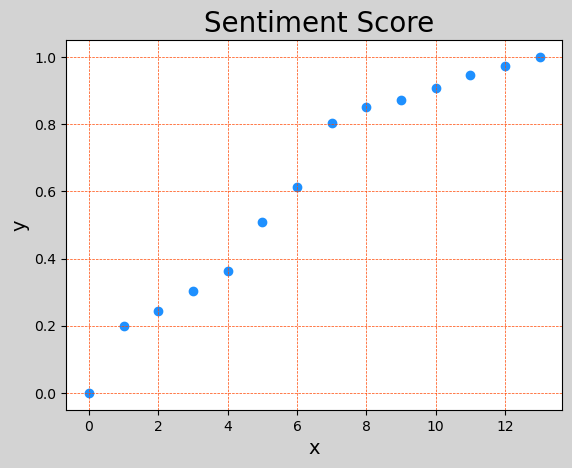

In [9]:
# 可视化代码
mp.figure('Sentiment Score', facecolor='lightgray')
mp.title(' Sentiment Score', fontsize=20)
mp.xlabel('x', fontsize=14)
mp.ylabel('y', fontsize=14)
ax = mp.gca()
ax.xaxis.set_minor_locator(
    mp.MultipleLocator(20))
ax.yaxis.set_minor_locator(
    mp.MultipleLocator())
ax.grid(which='major', axis='both', linewidth=0.5,
        linestyle='--', color='orangered')
mp.scatter(x, y, c='dodgerblue')
mp.show()

## 補充資料
### NTUSD： NTUSD由台灣大學整理並發布的情感詞  ，分為繁體中文和簡兩個版本。都包括有 2810個正面 情感詞語和 情感詞語和 8276個負面情感詞語。
https://github.com/data-science-lab/sentimentCN<br>



## B. 開始進入基于機器學習的NLP(文本情感分析)
### 首先要知道如何將「字詞」轉換成特徵「向量」形式，(記不記得之前為何把人臉特徵,手寫數字特徵量化?為的是計算相似度,近似度)，現在是為了計算 字詞 的 相似度，來表示文本語義上的相似度。

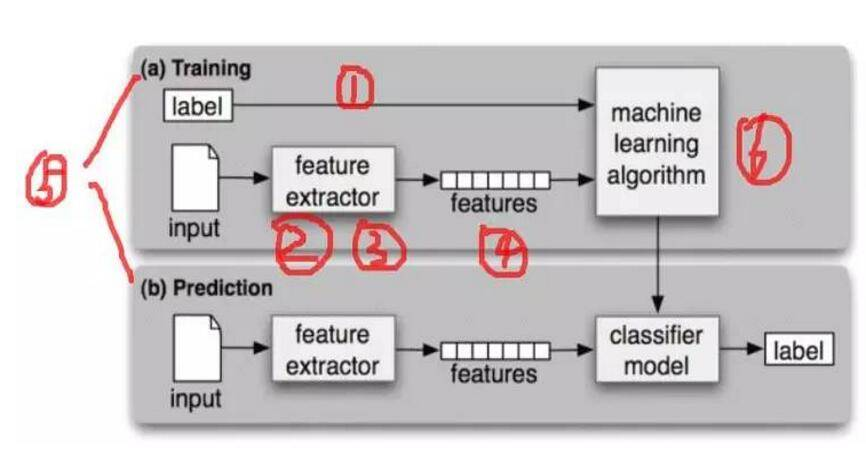

### 通常，我们面临的情感分析任务包括如下几类：

#### 是正面还是反面情绪？
Simplest task: Is the attitude of this text positive or negative?
#### 排序态度：
More complex: Rank the attitude of this text from 1 to 5
#### 检测目的、观点等：
Advanced: Detect the target, source, or complex attitude types
### 机器学习與词典匹配方法比較
### 机器学习精确度高，因为词典匹配会由于语义表达的丰富性而出现很大误差，而机器学习方法不会。
### 词典方法适用的语料范围更广，无论是手机、电脑这些商品，还是书评、影评这些语料，都可以适用。但机器学习则极度依赖语料，把手机语料训练出来的的分类器拿去给书评分类，那是注定要失败的。
## 使用机器学习进行情感分析，可以换一个相同意思的说法，就是用有监督的（需要人工标注类别）机器学习方法来对文本进行分类。
## 词典匹配是直接计算文本中的情感词，得出它们的情感倾向分值。
## 机器学习方法的思路是先选出一部分表达积极情感的文本和一部分表达消极情感的文本，用机器学习方法进行训练，获得一个情感分类器。再通过这个情感分类器对所有文本进行积极和消极的二分分类。最终的分类可以为文本给出0或1这样的类别，也可以给出一个概率值，比如”这个文本的积极概率是90%，消极概率是10%“。

### 1.工具套件:Word2vec
### 安装word2vec
### ==> 若您的執行環境是linux系統 ==> pip install word2vec
### ===>若您的執行環境是windows系統,上述指令安裝會出錯,可能還要先裝（Microsoft Visual C++ 14.0） Microsoft Visual C++ Build Tools
### ===>所以若是windows 環境,就用 Python 的 gensim 套件: https://pypi.python.org/pypi/gensim,
### 因為Word2vec　在此套件中,Gensim is a Python library for topic modelling, document indexing and similarity retrieval==>natural language processing (NLP) and information retrieval (IR)
### 注意　要裝 gemsim前,要確認 python 的　NumPy , Scipy 套件要先裝好(==>conda list )可查已裝套件
### ===>pip install -U gensim
### ====>在Python 中要使用word2vec 語法===>from gensim.models import word2vec
### word2vec （word to vector）是 Google 的一個開源工具，能夠根據輸入的「詞的集合」計算出詞與詞之間的距離的 機器學習演算法。
### 它將「字詞」轉換成「向量」形式，可以把對文本內容的處理簡化為向量空間中的向量運算，計算出向量空間上的相似度，來表示文本語義上的相似度。
###  <font color=red>在自然語言處理（NLP）相關任務中，要將自然語言交給機器學習中的演算法來處理，需要將語言數學化，因為機器不是人，機器只認量化數字化的數學符號。向量是人把自然界的東西抽象出來交給機器處理的東西，基本上可以說向量是人對機器輸入的主要方式了。</font>
### 詞向量就是用來將語言中的詞進行數學化的一種方式，顧名思義，詞向量就是把一個詞表示成一個向量。 在word2vec中，向量的每一維都表示一個特徵向量，作用於所有的單詞，而不是簡單的元素和值之間的一一對映。

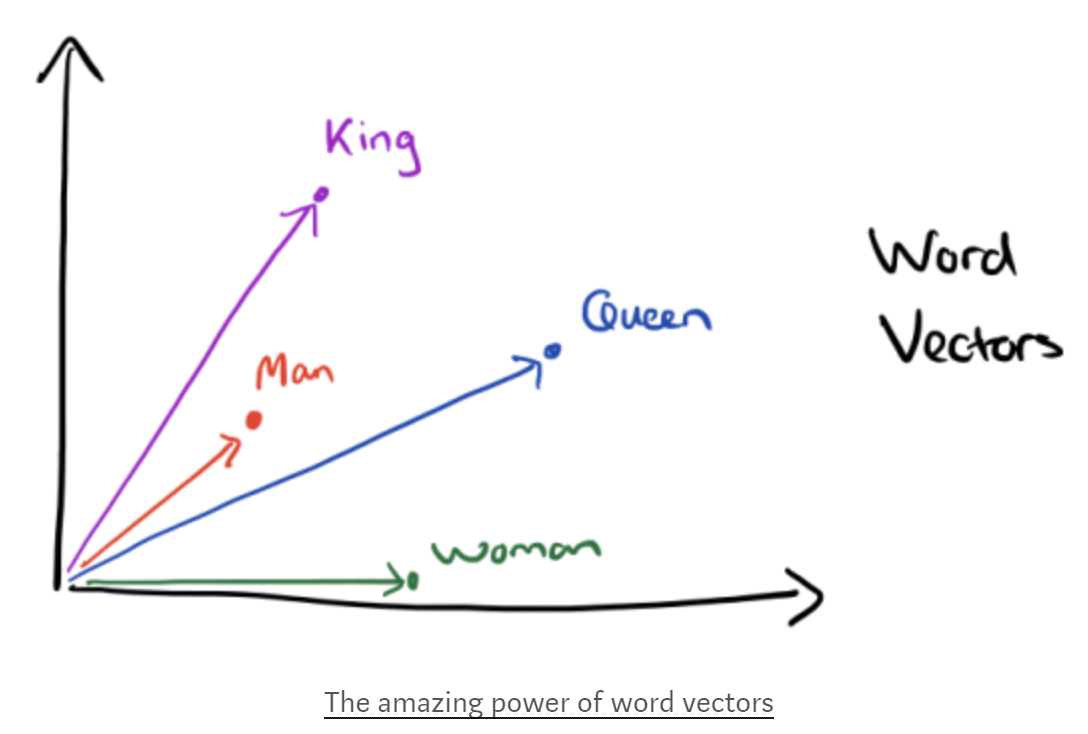

### word2vec如何轉換？
#### word2vec主要是將文本語料庫轉換成詞向量。它會先從訓練文本數據中構建一個詞彙，然後獲取向量表示詞，由此產生的詞向量可以作爲某項功能用在許多自然語言處理和機器學習應用中。
#### word2vec 計算的是餘弦值 (cosine)，距離範圍為 0–1 之間，值越大代表兩個詞關聯度越高。
##### 在舉例子之前，引入餘弦距離（Cosine distance）這個概念（摘自維基百科）：
###### 通過測量兩個向量內積空間的夾角的餘弦值來度量它們之間的相似性。0度角的餘弦值是1，而其他任何角度的餘弦值都不大於1;並且其最小值是-1。從而兩個向量之間的角度的餘弦值確定兩個向量是否大致指向相同的方向。兩個向量有相同的指向時，餘弦相似度的值爲1；兩個向量夾角爲90°時，餘弦相似度的值爲0；兩個向量指向完全相反的方向時，餘弦相似度的值爲-1。在比較過程中，向量的規模大小不予考慮，僅僅考慮到向量的指向方向。餘弦相似度通常用於兩個向量的夾角小於90°之內，因此餘弦相似度的值爲0到1之間。
##### 然後可以通過distance工具根據轉換後的向量計算出餘弦距離，來表示向量（詞語）的相似度。例如，你輸入“france”，distance工具會計算並顯示與“france”距離最相近的詞，如下：

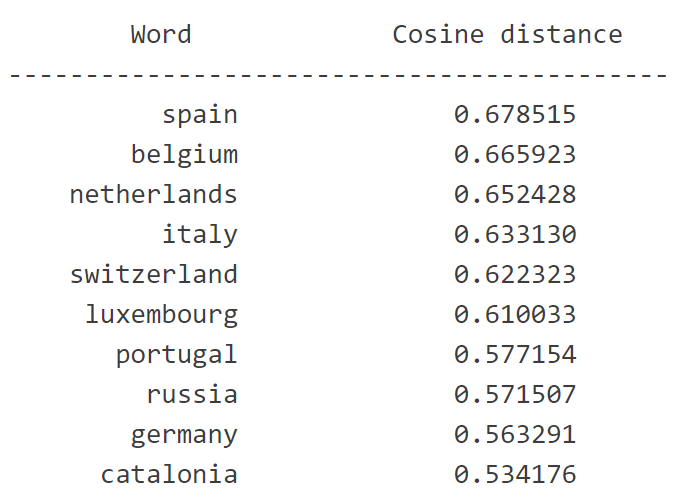

## 1.1 學習 基於Word2Vec 的相似度計算==>應用場景說明
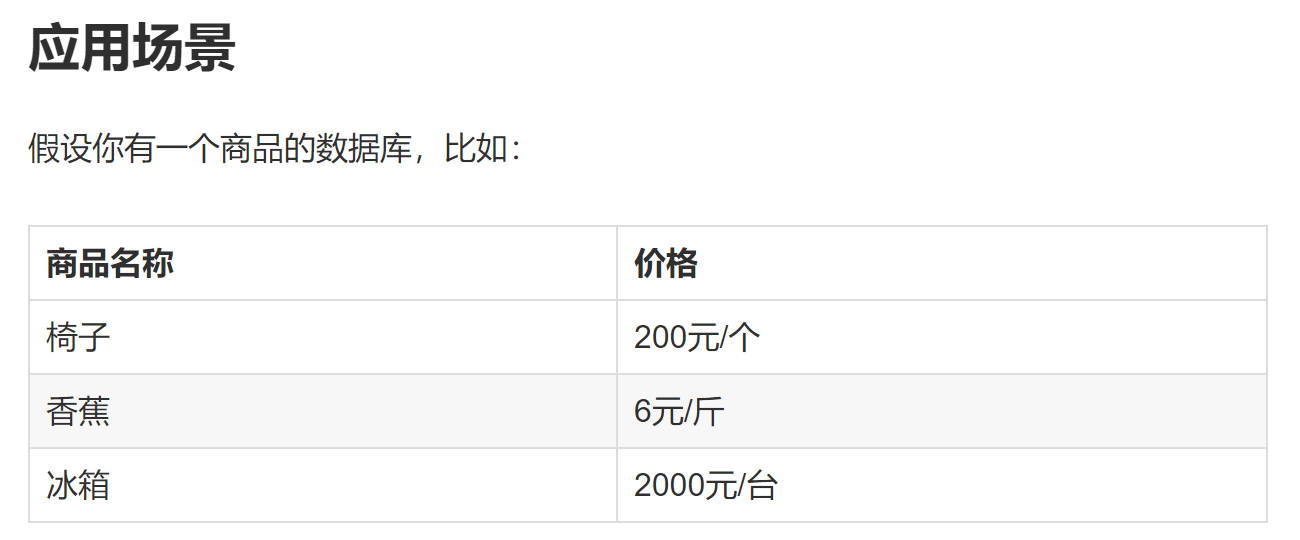

### 假如用户查詢商品時输入的是“凳子”，查的到商品嗎? 您的程式應該是會回覆没有此商品。
###  “凳子” 跟"椅子" 不是 同一功用或類型嗎? 要怎麼做才查的到? ==>同字義 或同語意 分析
### 方法:透過Word2Vec 機器學習方法做词语義相似度计算
### 找些文本來訓練==>一篇文章變成一句長字串==>文本斷詞==>留下有用關鍵詞==>word to vector
### 如　中文維基百科　https://zh.wikipedia.org/wiki/Wikipedia:%E6%95%B0%E6%8D%AE%E5%BA%93%E4%B8%8B%E8%BD%BD
https://dumps.wikimedia.org/zhwiki/latest/
### 輸入要找　同義詞　的　字==>word to vector ==>用Worde2Vec 相似度計算function 與前面文本的語料庫字詞做相似度計算==>傳回相似字詞
## Step1:文本資料預處理：首先將xml的wiki資料轉化成text格式,每篇文章變成一句長字串
### 利用gensim裡的維基百科處理類WikiCorpus，通過get_texts將維基裡的每篇文章轉換位1行text文字，並且去掉了標點符號等內容

### https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4

In [10]:
from gensim.corpora import WikiCorpus  

space =" "
i = 0 
output = open("wikidata.text", 'w',encoding="utf8")
wiki = WikiCorpus("zhwiki-latest-pages-articles4.xml-p2889649p3391029.bz2", dictionary={})
for text in wiki.get_texts():
    output.write(space.join(text) + "\n")
    i = i + 1
output.close()
print("Finished Saved " + str(i) + " articles")

d:\Users\hgtma\anaconda3\lib\site-packages\gensim\utils.py:1333: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected %s; aliasing chunkize to chunkize_serial" % entity)


Finished Saved 23182 articles


## Step2:進行中文分詞，使用jieba 分詞

In [37]:
import jieba
# read stop word
stopwordset = set()
with open("stopwords.txt", "r", encoding = "utf-8") as stopwords:
	for stopword in stopwords:
		stopwordset.add(stopword.strip('\n'))# strip 移除字尾　空格　或跳行符號
		#print(self.stopwordset)
print("StopWord Set 已儲存!")
        


StopWord Set 已儲存!


In [38]:
in_file=open("wikidata.text","r",encoding = "utf-8")
out_file = open("w_wikidata.text", 'w', encoding = "utf-8")
#jieba.load_userdict("dict.txt") # load 自建字典
texts_num = 0
while True:
    line=in_file.readline()
    if line:
        seg_list = jieba.cut(line)
        
        for word in seg_list:
            if word not in stopwordset:
                out_file.write(word+" ")
        texts_num += 1
        if texts_num % 500 == 0:
            print('已完成前 %d 行的斷詞' % texts_num)
       
    else:
        print('已完成 %d 行斷詞' % texts_num)
        break
            
in_file.close()    
out_file.close()

已完成前 500 行的斷詞
已完成前 1000 行的斷詞
已完成前 1500 行的斷詞
已完成前 2000 行的斷詞
已完成前 2500 行的斷詞
已完成前 3000 行的斷詞
已完成前 3500 行的斷詞
已完成前 4000 行的斷詞
已完成前 4500 行的斷詞
已完成前 5000 行的斷詞
已完成前 5500 行的斷詞
已完成前 6000 行的斷詞
已完成前 6500 行的斷詞
已完成前 7000 行的斷詞
已完成前 7500 行的斷詞
已完成前 8000 行的斷詞
已完成前 8500 行的斷詞
已完成前 9000 行的斷詞
已完成前 9500 行的斷詞
已完成前 10000 行的斷詞
已完成前 10500 行的斷詞
已完成前 11000 行的斷詞
已完成前 11500 行的斷詞
已完成前 12000 行的斷詞
已完成前 12500 行的斷詞
已完成前 13000 行的斷詞
已完成前 13500 行的斷詞
已完成前 14000 行的斷詞
已完成前 14500 行的斷詞
已完成前 15000 行的斷詞
已完成前 15500 行的斷詞
已完成前 16000 行的斷詞
已完成前 16500 行的斷詞
已完成前 17000 行的斷詞
已完成前 17500 行的斷詞
已完成前 18000 行的斷詞
已完成前 18500 行的斷詞
已完成前 19000 行的斷詞
已完成前 19500 行的斷詞
已完成前 20000 行的斷詞
已完成前 20500 行的斷詞
已完成前 21000 行的斷詞
已完成前 21500 行的斷詞
已完成前 22000 行的斷詞
已完成前 22500 行的斷詞
已完成前 23000 行的斷詞
已完成 23182 行斷詞


## Step3 執行word2vec模型訓練,以wiki 文本為訓練源
### word2vec 參數說明
#### LineSentence(　)：一行行讀取已斷詞文檔
#### size：是每个词的向量维度； 
#### window：是词向量训练时的上下文扫描窗口大小，窗口为5就是考虑前5个和后5个 
#### min-count：设置最低频率，默认是5，如果一个词语在文档中出现的次数小于5，那么就会丢弃 
#### workers：是训练的进程数，默认是当前运行机器的处理器核数。
#### 訓練word2vec模型，sg=1的意思為採用skip-gram,0為採用CBOW

In [40]:
import sys
import multiprocessing
 
from gensim.corpora import WikiCorpus
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence

# model = Word2Vec(LineSentence("w_wikidata.text"), sg=1, min_count=10)
#model = Word2Vec(LineSentence("w_wikidata.text"), size=400, window=5, min_count=5,workers=multiprocessing.cpu_count())
model = Word2Vec(LineSentence("w_wikidata.text"), window=5, min_count=5,workers=multiprocessing.cpu_count())

#### Anaconda -- C extension not loaded for Word2Vec
UserWarning: C extension not loaded for Word2Vec, training will be slow. Install a C compiler and reinstall gensim for fast training.
==>在Anaconda Prompt中依次輸入下面四條命令來解決

#### conda install mingw libpython 
#### pip uninstall gensim 
#### conda install gensim
#### pip install scipy

In [41]:
 # Save our model.
#model.save_word2vec_format('wikiseg.model', binary=False)    
model.save('wikiseg.model')

#### 训练结果可以通过model.save('fname')或model.save_word2vec_format(fname)来保存为文件，再使用model.load(fname)或model.load_word2vec_format(fname,encoding='utf-8')读取训练结果
前一组方法保存的文件不能利用文本编辑器查看但是保存了训练的全部信息，可以在读取后追加训练
后一组方法保存为word2vec文本格式但是保存时丢失了词汇树等部分信息，不能追加训练

In [42]:
# 导入模型
import gensim
model = gensim.models.Word2Vec.load('wikiseg.model')

## STep4 使用模型
### 计算词语之间的相似性:model.similarity(word1,word2)
### 计算最相似的词:model.most_similar(word[,topn,positive,negative])
topn表示返回前n个最相近的词
positive和negative用于类比，如positive=['woman', 'king'], negative=['man']，此时最合适的词应为queen
### 计算一组词中不匹配的词:model.doesnt_match(wordlist)
### 返回词向量:model[word],返回numpy.array类型对象

In [47]:
#print(model[u'汽车'])  
print(model.wv[u'汽车'])  

[ 1.4676299  -0.95235556 -0.40947315 -0.5166052   0.23791596  0.9809238
 -1.0828202  -0.07231604 -1.8252869   0.0314857   0.10438274 -0.5309795
  1.5997114   0.24028525  2.3499303   0.30932555  0.160753    0.68918246
 -2.1064315  -0.72963834 -1.4525814  -0.545125    0.18246242  0.4285983
  2.6588259  -0.818076    1.0905044  -0.8637056   1.4826716   0.0477605
 -0.5951043  -0.30320072  2.5699222  -2.9884953   0.8624676  -1.4059874
  0.8032621  -0.16500519  0.26218438 -0.2975554  -1.8954759  -2.3781838
  3.14111     2.0836802   0.33419767  0.14611919  1.6266254   1.5509301
 -1.0846218  -0.27044186  0.57042253 -0.19961421  2.0139947  -1.0732888
 -0.9928477   0.25182164  2.1661568   0.9047739   1.4382077  -0.03292635
 -1.1003836   0.2964849   0.3227207   3.786226   -1.5022672   0.6640261
  2.0097609  -0.94596636 -0.1977835   0.5592306  -0.10033289  0.1038655
  0.8895741   1.3988792   2.4910529   1.4465234   0.08944149  2.1765015
  1.0257944   0.10210346 -0.56665725  1.1246033   1.8442078  -

In [50]:
result = model.wv.most_similar(u'足球')
for each in result:    
    print(each[0] , each[1])

賽外 0.7454401850700378
美式足球 0.7267546653747559
德甲球 0.7208706140518188
冰球 0.7177427411079407
篮球 0.7087212204933167
入選過 0.7035538554191589
橄榄球 0.6986666917800903
隊上 0.6983433365821838
足球队 0.6961808204650879
五人制 0.6905256509780884


In [51]:
result = model.wv.most_similar(u'笔记')
for each in result:    
    print(each[0] , each[1])

首页 0.8756979703903198
回声 0.8656018972396851
档案 0.8654423356056213
中来 0.8645838499069214
刻画 0.8632522821426392
叙述 0.8617056012153625
写成 0.8613916635513306
题为 0.8600673079490662
解读 0.859070897102356
译文 0.8585044741630554


## C.构建機器學習情感分析流程
### 一、人工标注，需要人为的给文本一个类标签。

比如我有5000条商品评论，如果我要把这些评论分成积极和消极两类。那我就可以先从里面选2000条评论，然后对这2000条数据进行人工标注，把这2000条评论标为“积极”或“消极”。这“积极”和“消极”就是类标签。

假设有1000条评论被标为“积极”，有1000条评论被标为“消极”。(两者数量相同对训练分类器是有用的，如果实际中数量不相同，应该减少和增加数据以使得它们数量相同)
### 二、选择特征。

特征就是分类对象所展现的部分特点，是实现分类的依据。我们经常会做出分类的行为，那我们依据些什么进行分类呢?

举个例子，如果我看到一个年轻人，穿着新的正装，提着崭新的公文包，快步行走，那我就会觉得他是一个刚入职的职场新人。在这里面，“崭新”，“正装”，“公文包”，“快步行走”都是这个人所展现出的特点，也是我用来判断这个人属于哪一类的依据。这些特点和依据就是特征。可能有些特征对我判断更有用，有些对我判断没什么用，有些可能会让我判断错误，但这些都是我分类的依据。

我们没办法发现一个人的所有特点，所以我们没办法客观的选择所有特点，我们只能主观的选择一部分特点来作为我分类的依据。这也是特征选择的特点，需要人为的进行一定选择。

而在情感分类中，一般从“词”这个层次来选择特征。

比如这句话“手机非常好用!”，我给了它一个类标签“Positive”。里面有四个词(把感叹号也算上)，“手机”，“非常”，“好用”，“!”。我可以认为这4个词都对分类产生了影响，都是分类的依据。也就是无论什么地方出现了这四个词的其中之一，文本都可以被分类为“积极”。这个是把所有词都作为分类特征。

同样的，对这句话，我也可以选择它的双词搭配(Bigrams)作为特征。比如“手机 非常”，“非常 好用”，“好用 !”这三个搭配作为分类的特征。以此类推，三词搭配(Trigrams)，四词搭配都是可以被作为特征的。
### 三、特征降维。

特征降维说白了就是减少特征的数量。这有两个意义，一个是特征数量减少了之后可以加快算法计算的速度(数量少了当然计算就快了)，另一个是如果用一定的方法选择信息量丰富的特征，可以减少噪音，有效提高分类的准确率。

所谓信息量丰富，可以看回上面这个例子“手机非常好用!”，很明显，其实不需要把“手机”，“非常”，“好用”，“!”这4个都当做特征，因为“好用”这么一个词，或者“非常 好用”这么一个双词搭配就已经决定了这个句子是“积极”的。这就是说，“好用”这个词的信息量非常丰富。

那要用什么方法来减少特征数量呢?答案是通过一定的统计方法找到信息量丰富的特征。

统计方法包括：词频(Term Frequency)、文档频率(Document Frequency)、互信息(Pointwise Mutual Information)、信息熵(Information Entropy)、卡方统计(Chi-Square)等等。

在情感分类中，用词频选择特征，也就是选在语料库中出现频率高的词。比如我可以选择语料库中词频最高的2000个词作为特征。用文档频率选特征，是选在语料库的不同文档中出现频率最高的词。而其它三个，太高端冷艳，表示理解得还不清楚，暂且不表。。。

不过意思都是一样的，都是要通过某个统计方法选择信息量丰富的特征。特征可以是词，可以是词组合。
### 四、把语料文本变成使用特征表示。

在使用分类算法进行分类之前，第一步是要把所有原始的语料文本转化为特征表示的形式。

还是以上面那句话做例子，“手机非常好用!”

如果选择所有词作为特征，其形式是这样的：[ {“手机”: True, “非常”: True, “好用”: True, “!”: True} , positive]

如果选择双词作为特征，其形式是这样的：[ {“手机 非常”: True, “非常 好用”: True, “好用 !”: True} , positive ]

如果选择信息量丰富的词作为特征，其形式是这样的：[ {“好用”: True} , positive ]

无论使用什么特征选择方法，其形式都是一样的。都是[ {“特征1”: True, “特征2”: True, “特征N”: True, }, 类标签 ]
### 五、把用特征表示之后的文本分成开发集和测试集，把开发集分成训练集和开发测试集。

机器学习分类必须有数据给分类算法训练，这样才能得到一个(基于训练数据的)分类器。

有了分类器之后，就需要检测这个分类器的准确度。

根据《Python 自然语言处理》的方法，数据可以分为开发集合测试集。开发集专门用于不断调整和发现最佳的分类算法和特征维度(数量)，测试集应该一直保持“不被污染”。在开发集开发完毕之后，再使用测试集检验由开发集确定的最佳算法和特征维度的效果。
一般来说，训练集的数量应该远大于测试集，这样分类算法才能找出里面的规律，构建出高效的分类器。

用回前面的例子。假设2000条已经标注了积极和消极的评论数据，开发集可以是随机的1600条，测试集是剩余的随机400条。然后开发集中，训练集可以是随机的1400条，开发测试集是200条。
### 六、用不同的分类算法给训练集构建分类器，用开发测试集检验分类器的准确度(选出最佳算法后可以调整特征的数量来测试准确度)。

这个时候终于可以使用各种高端冷艳的机器学习算法啦!

我们的目标是：找到最佳的机器学习算法。
### 七、选择出开发集中最佳的分类算法和特征维度，使用测试集检验得出情感分类的准确度。

在终于得到最佳分类算法和特征维度(数量)之后，就可以动用测试集。

直接用最优的分类算法对测试集进行分类，得出分类结果。对比分类器的分类结果和人工标注的正确结果，给出分类器的最终准确度。

## D. 機器學習平台套件
## 因為機器學習需要先進行訓練,比較耗電腦資源,一般會在有GPU 的電腦上做訓練
## 也要有個訓練平台架構(訓練場),方便我們進行訓練,底下準備採用 google tensorflow,keras
## Keras 框架搭建安装,在CMD命令行或者Powershell中输入,先行安裝tensorflow

### ==>pip install --upgrade tensorflow

## Keras 安装
### ==>pip install keras -U --pre
之后可以验证keras是否安装成功,在命令行中输入Python命令进入Python变成命令行环境：>>> import keras

# E. 實作 基于LSTM 機器學習的三分类文本情感分析
## LSTM==>長短期記憶網路(Long Short Term Memory Network) 
### 練習採用機器學習的LSTM模型，训练一个能够识别文本 postive, neutral, negative三种情感(正面,中性,負面 評價)的分类器。
### https://www.potatomedia.co/post/355196c7-4c37-4ee4-a9cb-8c3ec965313d
### https://blog.csdn.net/weixin_38536057/article/details/78716355
### https://github.com/Edward1Chou/SentimentAnalysis
### https://daniel820710.medium.com/%E5%88%A9%E7%94%A8keras%E5%BB%BA%E6%A7%8Blstm%E6%A8%A1%E5%9E%8B-%E4%BB%A5stock-prediction-%E7%82%BA%E4%BE%8B-1-67456e0a0b
### https://github.com/erhwenkuo/deep-learning-with-keras-notebooks/blob/master/1.c-lstm-learn-alphabetic-seq.ipynb
### https://geek-docs.com/deep-learning/rnn/keras-lstm-tutorial.html
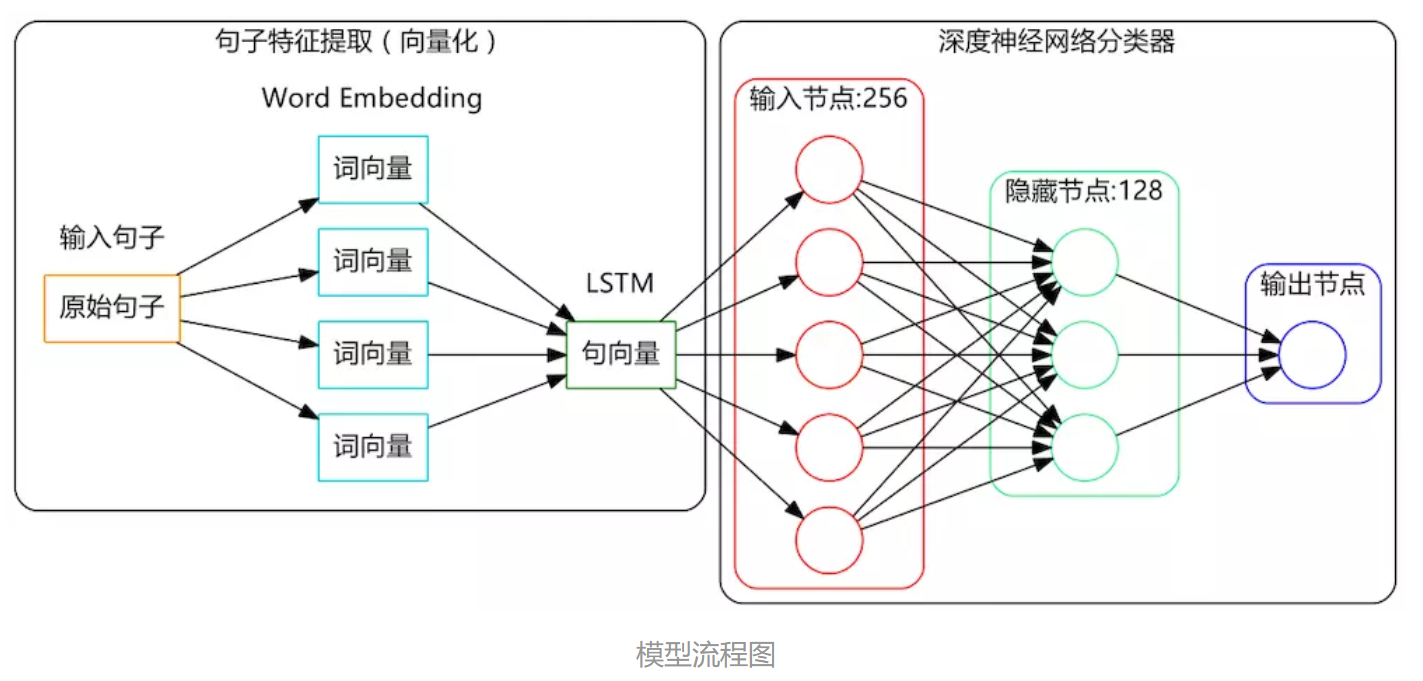

In [1]:
import tensorflow as tf; 
print(tf.__version__);
import keras; 
print(keras.__version__);

2.12.0
2.12.0


### Step1: 將  ML_sentiment 目錄下載回來 ,裡面有文本 data 檔
### Step2:讀取已分類好的訓練資料


In [2]:
#讀取已分類好的訓練資料
import pandas as pd

neg=pd.read_csv('ML_sentiment/data/neg.csv',header=None,index_col=None)
pos=pd.read_csv('ML_sentiment/data/pos.csv',header=None,index_col=None,error_bad_lines=False)
neu=pd.read_csv('ML_sentiment/data/neutral.csv', header=None, index_col=None)

C:\Users\hgtma\AppData\Local\Temp\ipykernel_2744\2022150910.py:5: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  pos=pd.read_csv('ML_sentiment/data/pos.csv',header=None,index_col=None,error_bad_lines=False)
Skipping line 2607: expected 1 fields, saw 9
Skipping line 3143: expected 1 fields, saw 2
Skipping line 3173: expected 1 fields, saw 8



In [3]:
# 顯示讀取至pd 的摘要,有就成功read
pos[0]

0       做父母一定要有刘墉这样的心态，不断地学习，不断地进步，不断地给自己补充新鲜血液，让自己保持一...
1       作者在战几时之前用了＂拥抱＂令人叫绝．日本如果没有战败，就有会有美军的占领，没胡官僚主义的延...
2       作者用诗一样的语言把如水般清澈透明的思想娓娓道来，像一个经验丰富的智慧老人为我们解开一个又一...
3       作者提出了一种工作和生活的方式，作为咨询界的元老，不仅能提出理念，而且能够身体力行地实践，并...
4       作者妙语连珠，将整个60-70年代用层出不穷的摇滚巨星与自身故事紧紧相连什么是乡愁？什么是摇...
                              ...                        
8025                                                   好评
8026                                                   好评
8027                                                   好评
8028                                                   好评
8029                                                   好评
Name: 0, Length: 8030, dtype: object

In [4]:
#combin 在一起 方便 tag ,訓練時一次讀取
import numpy as np

combined = np.concatenate((pos[0], neu[0], neg[0]))
combined.shape

(21088,)

### Step3:對訓練資料做Tag==>pos -> 1; neu -> 0; neg -> -1

In [5]:
# pos -> 1; neu -> 0; neg -> -1
y = np.concatenate((np.ones(len(pos), dtype=int), np.zeros(len(neu), dtype=int), -1*np.ones(len(neg),dtype=int)))
y.shape

(21088,)

### Step4:對訓練資料做斷詞

In [6]:
import jieba

#对句子经行分词，并去掉换行符
def tokenizer(text):
    ''' Simple Parser converting each document to lower-case, then
        removing the breaks for new lines and finally splitting on the
        whitespace
    '''
    text = [jieba.lcut(document.replace('\n', '')) for document in text]
    return text

combined = tokenizer(combined)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\hgtma\AppData\Local\Temp\jieba.cache
Loading model cost 1.866 seconds.
Prefix dict has been built successfully.


### Step5:對訓練資料轉成词向量,建立Word2vec model

In [7]:
from gensim.models.word2vec import Word2Vec
from gensim.corpora.dictionary import Dictionary
from keras.preprocessing import sequence
#from keras.utils.data_utils import pad_sequences
#from tensorflow.keras.preprocessing.sequence import pad_sequences
#from keras_preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences
import multiprocessing

cpu_count = multiprocessing.cpu_count() # 4
vocab_dim = 100
n_iterations = 10  # ideally more..
n_exposures = 10 # 所有频数超过10的词语
window_size = 7
n_epoch = 4
input_length = 100
maxlen = 100

def create_dictionaries(model=None,
                        combined=None):
    ''' Function does are number of Jobs:
        1- Creates a word to index mapping
        2- Creates a word to vector mapping
        3- Transforms the Training and Testing Dictionaries

    '''
    if (combined is not None) and (model is not None):
        gensim_dict = Dictionary()
        gensim_dict.doc2bow(model.wv.key_to_index.keys(),
                            allow_update=True) #(model.vocab.keys()
        #  freqxiao10->0 所以k+1
        w2indx = {v: k+1 for k, v in gensim_dict.items()}#所有频数超过10的词语的索引,(k->v)=>(v->k)
        w2vec = {word: model.wv[word] for word in w2indx.keys()}#所有频数超过10的词语的词向量, (word->model(word))

        def parse_dataset(combined): # 闭包-->临时使用
            ''' Words become integers
            '''
            data=[]
            for sentence in combined:
                new_txt = []
                for word in sentence:
                    try:
                        new_txt.append(w2indx[word])
                    except:
                        new_txt.append(0) # freqxiao10->0
                data.append(new_txt)
            return data # word=>index
        combined=parse_dataset(combined)
        combined= pad_sequences(combined, maxlen=maxlen)#每个句子所含词语对应的索引，所以句子中含有频数小于10的词语，索引为0
        return w2indx, w2vec,combined
    else:
        print ('No data provided...')


#创建词语字典，并返回每个词语的索引，词向量，以及每个句子所对应的词语索引
def word2vec_train(combined):

    model = Word2Vec(
                     min_count=n_exposures,
                     window=window_size,
                     workers=cpu_count) #size=vocab_dim,,iter=n_iterations
  
    model.build_vocab(combined) # input: list
    model.train(combined, epochs=model.epochs,total_examples=model.corpus_count)
    #（1）iteration：表示1次迭代（也叫training step），每次迭代更新1次网络结构的参数；
    #（2）batch-size：1次迭代所使用的样本量；
    #（3）epoch：1个epoch表示过了1遍训练集中的所有样本。
    # pickle模块是python中用来持久化对象的一个模块。所谓对对象进行持久化，
    # 即将对象的数据类型、存储结构、存储内容等所有信息作为文件保存下来以便下次使用==>.pkl
    model.save('ML_sentiment/model/Word2vec_model.pkl')
    index_dict, word_vectors,combined = create_dictionaries(model=model,combined=combined)
    return   index_dict, word_vectors,combined

print ('Training a Word2vec model...')
index_dict, word_vectors,combined=word2vec_train(combined)

Training a Word2vec model...


### Step6:開始將已轉成词向量的訓練資料進行LSTM 機器學習,並產出lstm model
### keras LSTM  Arguments
#### units: Positive integer, dimensionality of the output space.
#### activation: Activation function to use. Default: hyperbolic tangent (tanh). If you pass None, no activation is applied (ie. "linear" activation: a(x) = x).


In [8]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
#from keras.layers.embeddings import Embedding
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout,Activation
from keras.models import model_from_yaml
np.random.seed(1337)  # For Reproducibility
import sys
sys.setrecursionlimit(1000000)
import yaml
import keras

batch_size = 32


def get_data(index_dict,word_vectors,combined,y):

    n_symbols = len(index_dict) + 1  # 所有单词的索引数，频数小于10的词语索引为0，所以加1
    embedding_weights = np.zeros((n_symbols, vocab_dim)) # 初始化 索引为0的词语，词向量全为0
    for word, index in index_dict.items(): # 从索引为1的词语开始，对每个词语对应其词向量
        embedding_weights[index, :] = word_vectors[word]
    x_train, x_test, y_train, y_test = train_test_split(combined, y, test_size=0.2)
    y_train = keras.utils.to_categorical(y_train,num_classes=3) 
    y_test = keras.utils.to_categorical(y_test,num_classes=3)
    # print x_train.shape,y_train.shape
    return n_symbols,embedding_weights,x_train,y_train,x_test,y_test


##定义网络结构
def train_lstm(n_symbols,embedding_weights,x_train,y_train,x_test,y_test):
    print ('Defining a Simple Keras Model...')
    model = Sequential()  # or Graph or whatever
    model.add(Embedding(output_dim=vocab_dim,
                        input_dim=n_symbols,
                        mask_zero=True,
                        weights=[embedding_weights],
                        input_length=input_length))  # Adding Input Length
    #model.add(LSTM(3,output_dim=50, activation='tanh', inner_activation='hard_sigmoid'))
    model.add(LSTM(units=50, activation='tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax')) # Dense=>全连接层,输出维度=1
    model.add(Activation('softmax'))

    print ('Compiling the Model...')
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',metrics=['accuracy'])

    print ("Train...") # batch_size=32
    model.fit(x_train, y_train, batch_size=batch_size, epochs=n_epoch,verbose=1)

    print ("Evaluate...")
    score = model.evaluate(x_test, y_test,
                                batch_size=batch_size)

    yaml_string = model.to_json()
    with open('ML_sentiment/model/lstm.yml', 'w') as outfile:
        outfile.write( yaml.dump(yaml_string, default_flow_style=True) )
    model.save_weights('ML_sentiment/model/lstm.h5')
    print ('Test score:'+str(score))

print ('Setting up Arrays for Keras Embedding Layer...')
n_symbols,embedding_weights,x_train,y_train,x_test,y_test=get_data(index_dict, word_vectors,combined,y)
print ("x_train.shape and y_train.shape:")
print (x_train.shape,y_train.shape)
train_lstm(n_symbols,embedding_weights,x_train,y_train,x_test,y_test)

Setting up Arrays for Keras Embedding Layer...
x_train.shape and y_train.shape:
(16870, 100) (16870, 3)
Defining a Simple Keras Model...
Compiling the Model...
Train...
Epoch 1/4
528/528 [==============================] - 67s 110ms/step - loss: 0.9431 - accuracy: 0.5932
Epoch 2/4
528/528 [==============================] - 58s 110ms/step - loss: 0.7535 - accuracy: 0.8009
Epoch 3/4
528/528 [==============================] - 59s 111ms/step - loss: 0.6928 - accuracy: 0.8609
Epoch 4/4
528/528 [==============================] - 58s 110ms/step - loss: 0.6719 - accuracy: 0.8802
Evaluate...
132/132 [==============================] - 8s 39ms/step - loss: 0.6742 - accuracy: 0.8779
Test score:[0.674225389957428, 0.8779042363166809]


### Step7:訓練完以其產出的lstm model 進行預測

In [24]:
"""
预测
"""
import jieba
import numpy as np
from gensim.models.word2vec import Word2Vec
from gensim.corpora.dictionary import Dictionary
from keras.preprocessing import sequence
from keras.utils import pad_sequences
import yaml
from keras.models import model_from_yaml
np.random.seed(1337)  # For Reproducibility
import sys
sys.setrecursionlimit(1000000)

# define parameters
maxlen = 100

def create_dictionaries(model=None,
                        combined=None):
    ''' Function does are number of Jobs:
        1- Creates a word to index mapping
        2- Creates a word to vector mapping
        3- Transforms the Training and Testing Dictionaries

    '''
    if (combined is not None) and (model is not None):
        gensim_dict = Dictionary()
        gensim_dict.doc2bow(model.wv.key_to_index.keys(),
                            allow_update=True)
        #  freqxiao10->0 所以k+1
        w2indx = {v: k+1 for k, v in gensim_dict.items()}#所有频数超过10的词语的索引,(k->v)=>(v->k)
        w2vec = {word: model.wv[word] for word in w2indx.keys()}#所有频数超过10的词语的词向量, (word->model(word))

        def parse_dataset(combined): # 闭包-->临时使用
            ''' Words become integers
            '''
            data=[]
            for sentence in combined:
                new_txt = []
                for word in sentence:
                    try:
                        new_txt.append(w2indx[word])
                    except:
                        new_txt.append(0) # freqxiao10->0
                data.append(new_txt)
            return data # word=>index
        combined=parse_dataset(combined)
        combined= pad_sequences(combined, maxlen=maxlen)#每个句子所含词语对应的索引，所以句子中含有频数小于10的词语，索引为0
        return w2indx, w2vec,combined
    else:
        print ('No data provided...')


def input_transform(string):
    words=jieba.lcut(string)
    words=np.array(words).reshape(1,-1)
    model=Word2Vec.load('ML_sentiment/model/Word2vec_model.pkl')
    _,_,combined=create_dictionaries(model,words)
    return combined




In [57]:
import yaml
from keras.models import model_from_json
def lstm_predict(string):
    print ('loading model......')
    with open('ML_sentiment/model/lstm.yml', 'r') as f:
        yaml_string = yaml.load(f, Loader=yaml.Loader)
    model = model_from_json(yaml_string)

    print ('loading weights......')
    model.load_weights('ML_sentiment/model/lstm.h5')
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',metrics=['accuracy'])
    data=input_transform(string)
    data.reshape(1,-1)
    #print data 正面 中性 負面
    #result=model.predict_classes(data)
    result=model.predict(data)
    print (result) # [[1]]
    idx=result.argmax()
    print (idx)
    if idx==0:
        print (string,' positive')
    elif idx==1:
        print (string,' neutral')
    else:
        print (string,' negative')

In [60]:
#tring='酒店的环境非常好，价格也便宜，值得推荐'
#tring='手机质量太差了，傻逼店家，赚黑心钱，以后再也不会买了'
string = "这是我看过文字写得很糟糕的书，因为买了，还是耐着性子看完了，但是总体来说不好，文字、内容、结构都不好"
#sring = "虽说是职场指导书，但是写的有点干涩，我读一半就看不下去了！"
# string = "书的质量还好，但是内容实在没意思。本以为会侧重心理方面的分析，但实际上是婚外恋内容。"
# string = "不是太好"
# string = "不错不错"
#string = "非常好非常好！！"
# string = "真的一般，没什么可以学习的"

lstm_predict(string)

loading model......
loading weights......
1/1 [==============================] - 3s 3s/step
[[0.5759589  0.21198212 0.21205899]]
0
这是我看过文字写得很糟糕的书，因为买了，还是耐着性子看完了，但是总体来说不好，文字、内容、结构都不好  positive


In [ ]:
lstm_predict(string1)